패키지 참조 -> 데이터 셋 준비 -> 데이터 전처리 -> 탐색적 데이터 분석 -> 데이터 셋 분할 -> 모델 개발 -> 학습 결과 평가 -> 학습 결과 적용

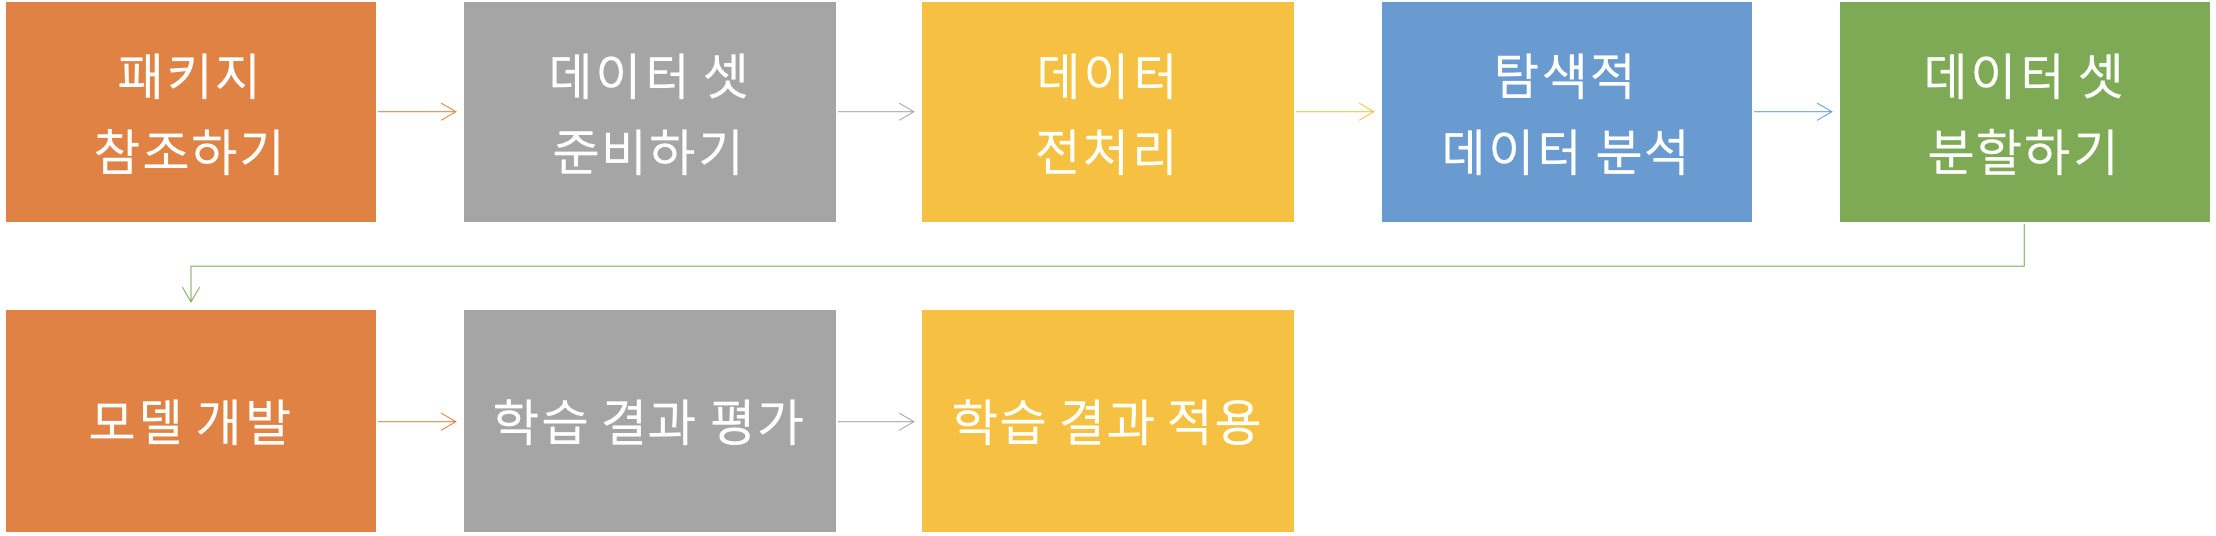

분석 프로세스를 진행한 이유와 해당 프로세서를 통해 얻은 결론을 설명
- 모든 단계는 목적과 근거를 제시

>머신러닝 - 소숫점 처리에 뛰어남

# 

# 췌장암 데이터 분류

## #01. 패키지

In [1]:
import sys
sys.path.append("../../../")
import helper

import numpy as np
from pandas import read_excel, DataFrame, get_dummies
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

## #02. 데이터셋 준비

In [2]:
origin = read_excel("https://data.hossam.kr/F03/biostat.xlsx")
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  156 non-null    int64         
 1   age                 156 non-null    int64         
 2   sex                 156 non-null    int64         
 3   weight              156 non-null    float64       
 4   OP_date             156 non-null    datetime64[ns]
 5   Recur               156 non-null    int64         
 6   Recur_1y            156 non-null    int64         
 7   Recur_date          156 non-null    datetime64[ns]
 8   SBP                 156 non-null    float64       
 9   CA19.9              156 non-null    float64       
 10  CRP                 156 non-null    float64       
 11  CEA                 156 non-null    float64       
 12  post.CEA            156 non-null    float64       
 13  stage               156 non-null    int64         

In [3]:
origin.head()

,id,age,sex,weight,OP_date,Recur,Recur_1y,Recur_date,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
0,1,82,1,73.994588,2014-07-10,1,0,2015-08-12,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
1,2,50,0,64.819694,2013-05-08,0,0,2018-07-07,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
2,3,28,1,63.204675,2016-05-06,0,0,2020-01-13,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
3,4,35,1,52.499192,2015-11-24,1,0,2017-08-07,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
4,5,49,1,72.766264,2015-02-12,1,0,2016-06-02,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


| 필드명 | 비고 |
| -- | -- |
| sex | 0=여성, 1=남성 |
| Recur | 1=재발, 0=마지막 관찰시점까지 재발 안함 |
| Recur_1y | 1=1년 내 재발, 0=1년 내 재발 안함 |
| Recur_date | 재발하지 않은 환자의 경우 마지막 검사 날짜 |
| stage | 1, 2, 3 |
| smoking | 1=흡연, 0=비흡연 |
| obesity | 1=비만, 0=정상 |

## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isna().sum()

id                    0
age                   0
sex                   0
weight                0
OP_date               0
Recur                 0
Recur_1y              0
Recur_date            0
SBP                   0
CA19.9                0
CRP                   0
CEA                   0
post.CEA              0
stage                 0
smoking               0
obesity               0
post.CA19.9           0
post.CA19.9.binary    0
post.CA19.9.3grp      0
dtype: int64

> 결측치 없음

### 결측치 정제

#### 날짜 데이터 제거

In [5]:
# origin.columns

In [6]:
df1 = origin.drop(['OP_date', 'Recur_date'], axis=1)
df1.head()

,id,age,sex,weight,Recur,Recur_1y,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
0,1,82,1,73.994588,1,0,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
1,2,50,0,64.819694,0,0,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
2,3,28,1,63.204675,0,0,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
3,4,35,1,52.499192,1,0,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
4,5,49,1,72.766264,1,0,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


### index 설정

In [7]:
# id를 DF의 Index로
df2 = df1.set_index("id")
df2.head()

,age,sex,weight,Recur,Recur_1y,SBP,CA19.9,CRP,CEA,post.CEA,stage,smoking,obesity,post.CA19.9,post.CA19.9.binary,post.CA19.9.3grp
id,,,,,,,,,,,,,,,,
1,82,1,73.994588,1,0,144.286869,4490.5,0.1,3.0,5.1,3,1,1,36.795194,0,1
2,50,0,64.819694,0,0,108.590964,36.7,0.1,1.1,1.5,3,1,0,32.765043,0,1
3,28,1,63.204675,0,0,5.629379,36.7,0.1,10.7,12.4,3,1,0,31.133072,0,1
4,35,1,52.499192,1,0,143.931300,64.9,1.3,1.3,0.4,3,1,1,36.134051,0,1
5,49,1,72.766264,1,0,172.653143,38.2,10.7,3.7,0.4,3,1,0,33.921657,0,1


### 더미변수 처리

범주형(명목형) 데이터(카테고리가 1~3등급)를 각 카테고리별로 나누어 표현 
- 명목형은 계산할 수 있는 값이 아니기 때문

ex) 태아의 성별, 위암 등급, 승무원의 등급

In [8]:
df2.columns

Index(['age', 'sex', 'weight', 'Recur', 'Recur_1y', 'SBP', 'CA19.9', 'CRP',
       'CEA', 'post.CEA', 'stage', 'smoking', 'obesity', 'post.CA19.9',
       'post.CA19.9.binary', 'post.CA19.9.3grp'],
      dtype='object')

In [9]:
cda_df = get_dummies(df2, columns=['stage', 'post.CA19.9.3grp'], drop_first=True, dtype='int')
cda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 1 to 156
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 156 non-null    int64  
 1   sex                 156 non-null    int64  
 2   weight              156 non-null    float64
 3   Recur               156 non-null    int64  
 4   Recur_1y            156 non-null    int64  
 5   SBP                 156 non-null    float64
 6   CA19.9              156 non-null    float64
 7   CRP                 156 non-null    float64
 8   CEA                 156 non-null    float64
 9   post.CEA            156 non-null    float64
 10  smoking             156 non-null    int64  
 11  obesity             156 non-null    int64  
 12  post.CA19.9         156 non-null    float64
 13  post.CA19.9.binary  156 non-null    int64  
 14  stage_2             156 non-null    int32  
 15  stage_3             156 non-null    int32  
 16  post.CA19.9.3

In [10]:
cda_df.head()

,age,sex,weight,Recur,Recur_1y,SBP,CA19.9,CRP,CEA,post.CEA,smoking,obesity,post.CA19.9,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,,,
1,82,1,73.994588,1,0,144.286869,4490.5,0.1,3.0,5.1,1,1,36.795194,0,0,1,0,0
2,50,0,64.819694,0,0,108.590964,36.7,0.1,1.1,1.5,1,0,32.765043,0,0,1,0,0
3,28,1,63.204675,0,0,5.629379,36.7,0.1,10.7,12.4,1,0,31.133072,0,0,1,0,0
4,35,1,52.499192,1,0,143.931300,64.9,1.3,1.3,0.4,1,1,36.134051,0,0,1,0,0
5,49,1,72.766264,1,0,172.653143,38.2,10.7,3.7,0.4,1,0,33.921657,0,0,1,0,0


## #05. 데이터셋 분할

### 랜덤시드 고정

In [11]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [12]:
x = cda_df.drop('Recur_1y', axis=1)
x.head()

,age,sex,weight,Recur,SBP,CA19.9,CRP,CEA,post.CEA,smoking,obesity,post.CA19.9,post.CA19.9.binary,stage_2,stage_3,post.CA19.9.3grp_2,post.CA19.9.3grp_3
id,,,,,,,,,,,,,,,,,
1,82,1,73.994588,1,144.286869,4490.5,0.1,3.0,5.1,1,1,36.795194,0,0,1,0,0
2,50,0,64.819694,0,108.590964,36.7,0.1,1.1,1.5,1,0,32.765043,0,0,1,0,0
3,28,1,63.204675,0,5.629379,36.7,0.1,10.7,12.4,1,0,31.133072,0,0,1,0,0
4,35,1,52.499192,1,143.931300,64.9,1.3,1.3,0.4,1,1,36.134051,0,0,1,0,0
5,49,1,72.766264,1,172.653143,38.2,10.7,3.7,0.4,1,0,33.921657,0,0,1,0,0


In [13]:
y = cda_df[['Recur_1y']]
y.head()

,Recur_1y
id,
1,0
2,0
3,0
4,0
5,0


### 훈련 데이터와 검증 데이터로 분할

In [14]:
# 표준화 미진행 - x,y 사용
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((109, 17), (47, 17), (109, 1), (47, 1))

## #06. 모델 개발

### 모델 정의

> [relu], sigmoid, rmsporp, binary_crossentropy, acc

- input_shape은 독립변수 수
- Dense 신경망 개수의 수에 따라서 모델의 성능에 차이가 발생
    - 직감으로 맞춤(다른 방법 없음) 보통 16 또는 32 이상
    - 최적의 값을 직접 탐색(너무 많으면 컴퓨터 다운)
- activation은 모델과 분석 종류에 따라서 다름 
    - 보통 시작은 relu, 분류는 sigmoid, 회귀는 linear
- optimizer은 모르면 Adam
- epochs는 많아도 크게 상관이 없음
- 2차항을 하고 싶다면 sklearn으로 2차항 생성 후 Sequential에 입력

In [15]:
model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape=(17, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                576       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 609 (2.38 KB)
Trainable params: 609 (2.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

- epochs는 많아도 크게 상관이 없음(단, 너무 크면 오래 걸리고 오차가 증가)
    - callback을 사용해 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링
    - EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ReduceLROnPlateau EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 `평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백`
    - ModelCheckpoint 지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

In [16]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500


4/4 [==============================] - 1s 74ms/step - loss: 12.7023 - acc: 0.6789 - val_loss: 23.7427 - val_acc: 0.5957 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 15ms/step - loss: 8.4151 - acc: 0.6972 - val_loss: 17.0587 - val_acc: 0.6383 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 31ms/step - loss: 5.8128 - acc: 0.7064 - val_loss: 14.4459 - val_acc: 0.6383 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 4.7412 - acc: 0.7248 - val_loss: 11.5312 - val_acc: 0.5957 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 3.9388 - acc: 0.6514 - val_loss: 10.3052 - val_acc: 0.5957 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 15ms/step - loss: 3.6143 - acc: 0.6330 - val_loss: 8.8072 - val_acc: 0.5745 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 19ms/step - loss: 3.1958 - acc: 0.6239 - val_loss: 7.3998 - val_acc: 0.6596 - lr: 0.0010
Epoch

## #07. 학습결과 평가

### 기본적인 머신러닝 학습률 평가

In [17]:
# 학습결과 시각화
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,12.702271,0.678899,23.742718,0.595745,0.0010
2,8.415125,0.697248,17.058722,0.638298,0.0010
3,5.812796,0.706422,14.445927,0.638298,0.0010
4,4.741204,0.724771,11.531192,0.595745,0.0010
5,3.938778,0.651376,10.305208,0.595745,0.0010
6,3.614337,0.633027,8.807156,0.574468,0.0010
7,3.195828,0.623853,7.399787,0.659574,0.0010
8,2.772306,0.669725,5.685864,0.574468,0.0010
9,2.324916,0.623853,3.023217,0.617021,0.0010


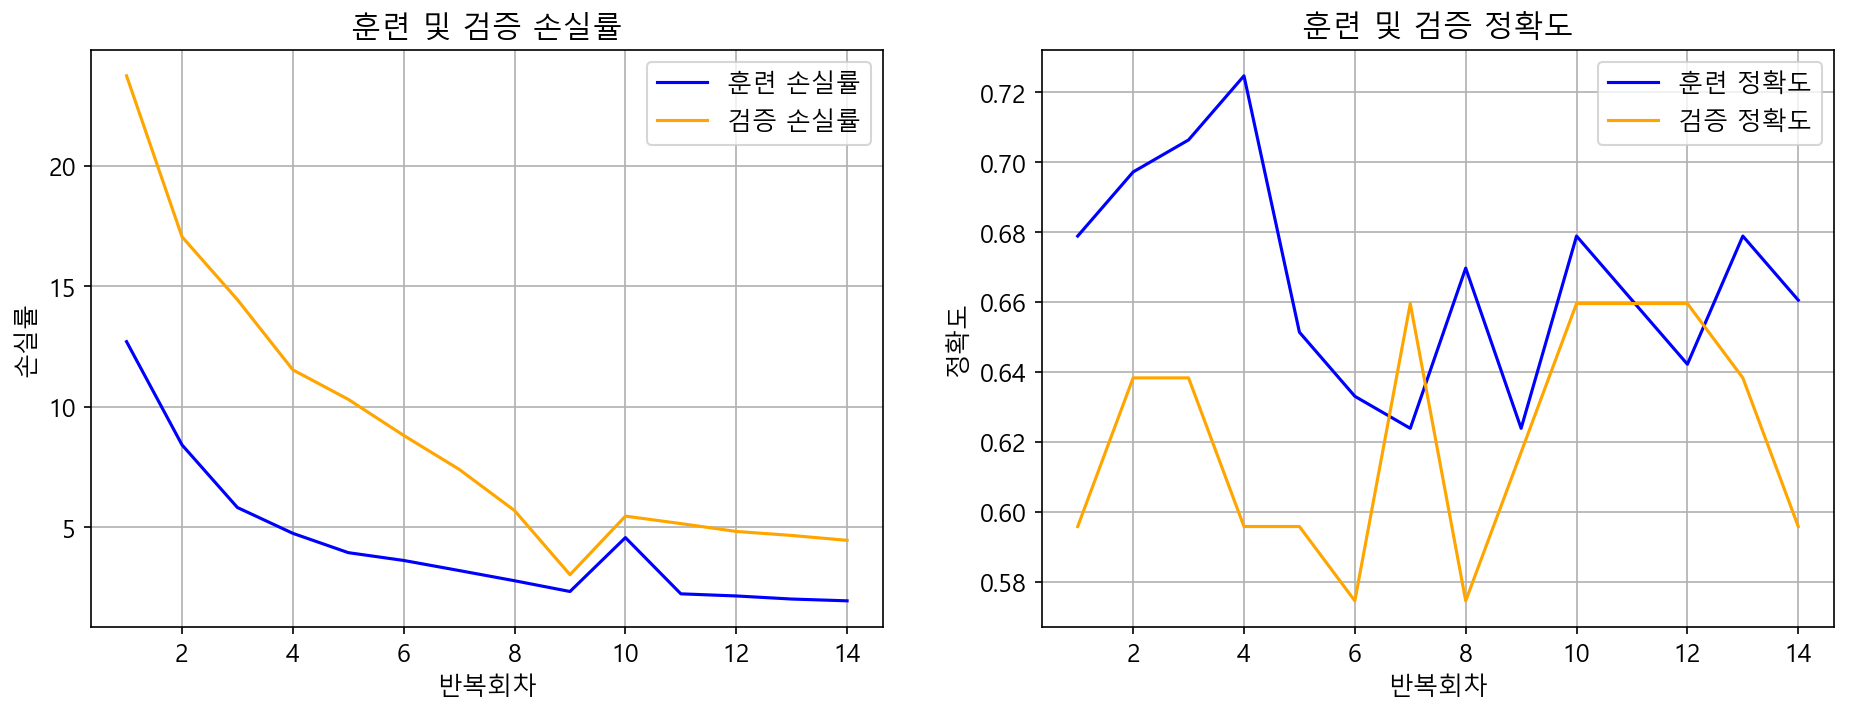

In [18]:
# ------------------------------
# 그래프 초기화
# ------------------------------
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False
# ------------------------------
# 그래프를 그리기 위한 객체 생성
# ------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
# ------------------------------
# 1) 훈련 및 검증 손실 그리기
# ------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# ------------------------------
# 2) 훈련 및 검증 정확성
# ------------------------------
sb.lineplot(x=result_df.index, y='acc', data=result_df, color = 'blue', label = '훈련 정확도', ax=ax2)
sb.lineplot(x=result_df.index, y='val_acc', data=result_df, color = 'orange', label = '검증 정확도', ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [19]:
# helper.tf_result_plot(result)

In [20]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률 : %f, 최종 훈련 정확도 : %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률 : %f, 최종 검증 정확도 : %f" % (evaluate2[0], evaluate2[1]))

4/4 [==============================] - 0s 3ms/step - loss: 1.8919 - acc: 0.6055


최종 훈련 손실률 : 1.891891, 최종 훈련 정확도 : 0.605505
2/2 [==============================] - 0s 12ms/step - loss: 4.4495 - acc: 0.5957
최종 검증 손실률 : 4.449486, 최종 검증 정확도 : 0.595745


In [21]:
logit_result = helper.tf_logit_result(model, result, x_train, y_train)

4/4 [==============================] - 0s 2ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                576       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 609 (2.38 KB)
Trainable params: 609 (2.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
logit_result.cmdf

,Negative,Positive
True,48,17
False,26,18


In [23]:
logit_result.odds_rate_df

array([1.0208752], dtype=float32)

In [24]:
logit_result.result_df.T
# helper.prettyPrint(logit_result.result_df.T)

,0
정확도(Accuracy),0.605505
정밀도(Precision),0.409091
"재현율(Recall, TPR)",0.514286
"위양성율(Fallout, FPR)",0.351351
"특이성(Specificity, TNR)",0.648649
RAS,0.581467
f1_score,0.455696
